# Criando a base de dados para treinamento e validação a partir da base de imagens

Esse programa tem como objetivo extrair as features, criar o dataset com com elas (X,y) e salvar na memória para ser usado nos demais programas (treinamento e testes).


In [1]:
import cv2
import dlib
import numpy as np
import os,glob

import myUtils
from myUtils import facial_landmarks_idxs as facial_pts_idxs

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# identificador dos landmarks
predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")

In [3]:
ORIG_DATASET_DIR = "../dataset_B_Facial_Images/"
ORIG_CLOSED_DIR  = "../dataset_B_Facial_Images/ClosedFace/"
ORIG_OPENED_DIR  = "../dataset_B_Facial_Images/OpenFace/"

In [4]:
# Criando diretório
try:
    os.mkdir("dataset")
    os.mkdir("dataset/train")
    os.mkdir("dataset/test")
except:
    #Caso já exista: deletar todos os arquivos dentro do diretório
    os.system("rm -rf dataset")
    
    os.mkdir("dataset")
    os.mkdir("dataset/train")
    os.mkdir("dataset/test")

## Carregando Dataset de Imagens Original

In [5]:
#load dataset original
faces_closed_path = [f.replace(ORIG_CLOSED_DIR,"") for f in glob.glob(os.path.join(ORIG_CLOSED_DIR, "*.jpg"))]
faces_opened_path = [f.replace(ORIG_OPENED_DIR,"") for f in glob.glob(os.path.join(ORIG_OPENED_DIR, "*.jpg"))]
faces_closed = []
faces_opened = []

#carregar imagens de "faces fechadas"
for file in glob.glob(os.path.join(ORIG_CLOSED_DIR, "*.jpg")):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, ksize=(3,3), sigmaX=0) #leve suavização na imagem
    faces_closed.append(img)

#Carregar images de "faces abertas"
for file in glob.glob(os.path.join(ORIG_OPENED_DIR, "*.jpg")):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, ksize=(3,3), sigmaX=0) #leve suavização na imagem
    faces_opened.append(img)

### Verificando como as classes estão distribuidas

**Obs.:** Codificação das labels:

| Estado dos olhos | y |
|:--------------:|:-------------:|
|       Fechado        |       0       |
|       Aberto        |       1       |

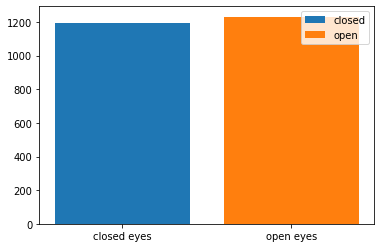

In [6]:
fig, ax = plt.subplots()

ax.bar(0, len(faces_closed), label='closed')
ax.bar(1, len(faces_opened), label='open')
ax.legend()
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(['closed eyes', 'open eyes'])
plt.show()

Conclusão sobre a distribuição dos dados: Classes equilibradas com relação a quantidade.

## Extração das Features e Criação do Train set and Test set

In [7]:
import pandas as pd

In [8]:
X = []
y = []

for face in faces_closed:
    landmarks = myUtils.get_landmarks(face, predictor)
    features = myUtils.feature_extrator_EAR_HIST(face, landmarks)
    X.append(features)

for face in faces_opened:
    landmarks = myUtils.get_landmarks(face, predictor)
    features = myUtils.feature_extrator_EAR_HIST(face, landmarks)
    X.append(features)

faces_img = np.array(faces_closed + faces_opened)

y = [0]*len(faces_closed) + [1]*len(faces_opened)

X = np.array(X).reshape(-1,10)
y = np.array(y)

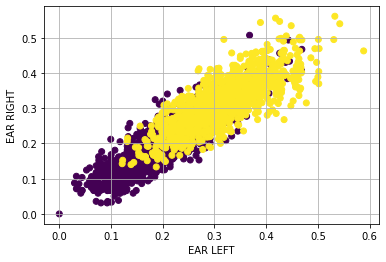

In [9]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.grid()
plt.xlabel("EAR LEFT")
plt.ylabel("EAR RIGHT")
plt.show()

In [10]:
df = pd.DataFrame()
df["img_code"] = faces_closed_path + faces_opened_path
df[ [f"X{i}" for i in range(X.shape[1])] ] = X
df["y"] = y

In [11]:
df.head()

,img_code,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
0,closed_eye_2420.jpg_face_1.jpg,0.141421,0.162926,0.000000,0.000000,0.885635,0.463904,0.021087,0.000000,0.000000,0.0,0
1,closed_eye_1507.jpg_face_3.jpg,0.175893,0.100000,0.000000,0.000000,0.000000,0.550344,0.825516,0.125078,0.000000,0.0,0
2,closed_eye_0464.jpg_face_1.jpg,0.281250,0.314980,0.993097,0.115701,0.019283,0.000000,0.000000,0.000000,0.000000,0.0,0
3,closed_eye_0309.jpg_face_1.jpg,0.469021,0.467034,0.000000,0.030291,0.060582,0.507372,0.772417,0.355918,0.121163,0.0,0
4,closed_eye_0476.jpg_face_1.jpg,0.228086,0.275585,0.000000,0.912830,0.339658,0.148600,0.148600,0.084914,0.000000,0.0,0


In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

#reseting the index column
df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

### Salvando na memória

In [13]:
df.to_csv("dataset/data_set.csv")
df_train.to_csv("dataset/train_set.csv")
df_test.to_csv("dataset/test_set.csv")

In [14]:
for i in range(df_train.shape[0]):
    cmd = f"cp {ORIG_CLOSED_DIR}{df_train['img_code'][i]} dataset/train/"
    os.system(cmd)
for i in range(df_test.shape[0]):
    cmd = f"cp {ORIG_OPENED_DIR}{df_test['img_code'][i]} dataset/test/"
    os.system(cmd)

## Apenas Demostrando/Testando As Principais Funções

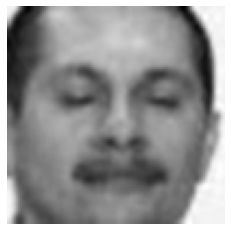

In [15]:
rand_idx = np.random.randint(len(faces_img))
rand_img = faces_img[rand_idx]


plt.imshow(rand_img,cmap='gray')
plt.axis('off')
plt.show()

#### 68 Landmarks Predictor

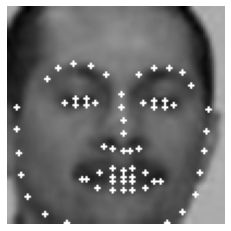

In [16]:
landmarks  = myUtils.get_landmarks(rand_img, predictor)
img_marked = myUtils.draw_landmarks(rand_img, landmarks)

plt.imshow(img_marked,'gray')
plt.axis('off')
plt.show()

#### Segmentação da região dos olhos

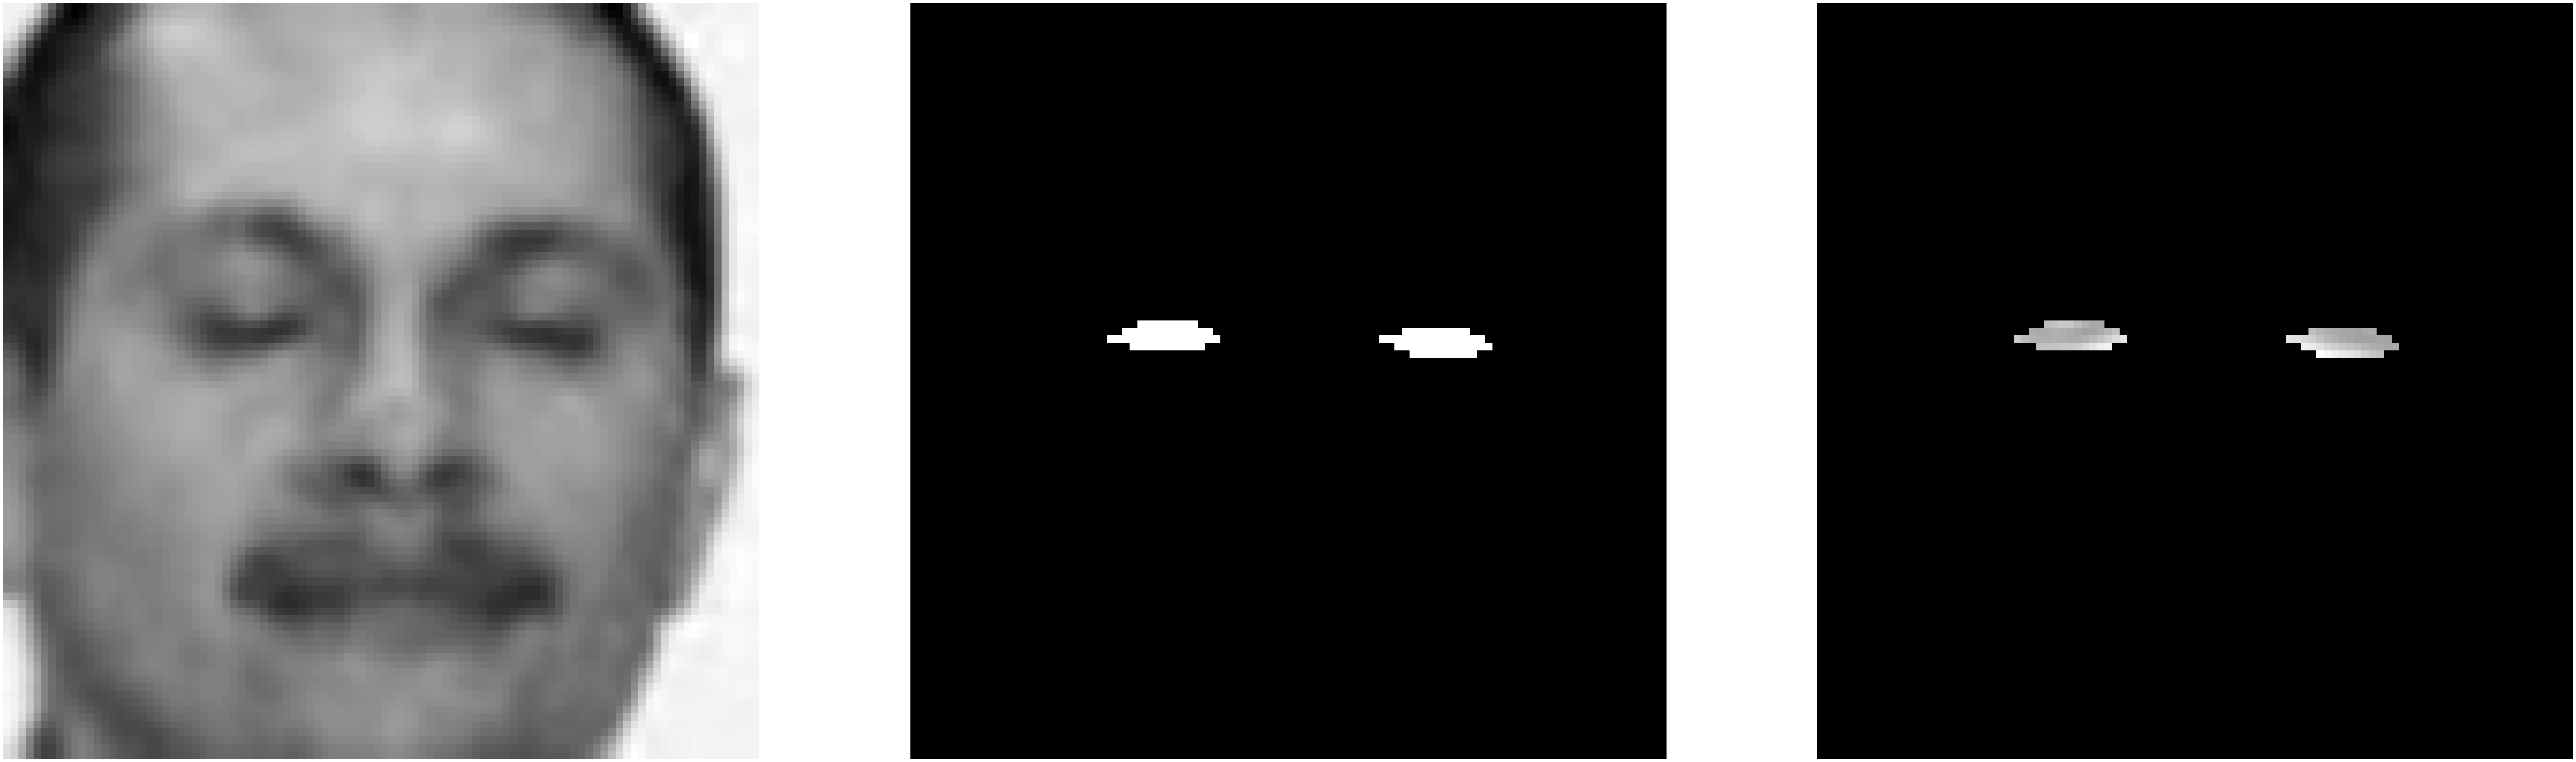

In [17]:
segmented, mask = myUtils.eyes_segmentation(rand_img, landmarks)

fig, axes = plt.subplots(1,3, figsize=(100,300))

axes[0].imshow(rand_img,'gray')
axes[1].imshow(mask,'gray')
axes[2].imshow(segmented,'gray')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.show()

#### Extração das features

In [18]:
myUtils.feature_extrator_EAR_HIST(rand_img, landmarks)

[0.21428571428571427,
 0.21374114996372895,
 0.0,
 0.0,
 0.966008722782135,
 0.2585093677043915,
 0.0,
 0.0,
 0.0,
 0.0]